In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt

import os

In [ ]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [ ]:
FORDER_PATH = './DATA/cifar-10-batches-py/'

In [ ]:
forder_list = os.listdir(FORDER_PATH)
print(forder_list)

['batches.meta', 'data_batch_1', 'data_batch_2', 'data_batch_3', 'data_batch_4', 'data_batch_5', 'readme.html', 'test_batch']


In [ ]:
label_names = unpickle(FORDER_PATH+forder_list[0])[b'label_names']
print(label_names)

[b'airplane', b'automobile', b'bird', b'cat', b'deer', b'dog', b'frog', b'horse', b'ship', b'truck']


In [ ]:
data = {'data':[], 'labels':[]}
for f in forder_list[1:6]:
    file_dict = unpickle(FORDER_PATH+f)
    data['data'].extend(file_dict[b'data'].reshape(10000,3,32,32))
    data['labels'].extend(file_dict[b'labels'])

In [ ]:
datad = unpickle(FORDER_PATH+forder_list[1])
datad[b'labels']

[6,
 9,
 9,
 4,
 1,
 1,
 2,
 7,
 8,
 3,
 4,
 7,
 7,
 2,
 9,
 9,
 9,
 3,
 2,
 6,
 4,
 3,
 6,
 6,
 2,
 6,
 3,
 5,
 4,
 0,
 0,
 9,
 1,
 3,
 4,
 0,
 3,
 7,
 3,
 3,
 5,
 2,
 2,
 7,
 1,
 1,
 1,
 2,
 2,
 0,
 9,
 5,
 7,
 9,
 2,
 2,
 5,
 2,
 4,
 3,
 1,
 1,
 8,
 2,
 1,
 1,
 4,
 9,
 7,
 8,
 5,
 9,
 6,
 7,
 3,
 1,
 9,
 0,
 3,
 1,
 3,
 5,
 4,
 5,
 7,
 7,
 4,
 7,
 9,
 4,
 2,
 3,
 8,
 0,
 1,
 6,
 1,
 1,
 4,
 1,
 8,
 3,
 9,
 6,
 6,
 1,
 8,
 5,
 2,
 9,
 9,
 8,
 1,
 7,
 7,
 0,
 0,
 6,
 9,
 1,
 2,
 2,
 9,
 2,
 6,
 6,
 1,
 9,
 5,
 0,
 4,
 7,
 6,
 7,
 1,
 8,
 1,
 1,
 2,
 8,
 1,
 3,
 3,
 6,
 2,
 4,
 9,
 9,
 5,
 4,
 3,
 6,
 7,
 4,
 6,
 8,
 5,
 5,
 4,
 3,
 1,
 8,
 4,
 7,
 6,
 0,
 9,
 5,
 1,
 3,
 8,
 2,
 7,
 5,
 3,
 4,
 1,
 5,
 7,
 0,
 4,
 7,
 5,
 5,
 1,
 0,
 9,
 6,
 9,
 0,
 8,
 7,
 8,
 8,
 2,
 5,
 2,
 3,
 5,
 0,
 6,
 1,
 9,
 3,
 6,
 9,
 1,
 3,
 9,
 6,
 6,
 7,
 1,
 0,
 9,
 5,
 8,
 5,
 2,
 9,
 0,
 8,
 8,
 0,
 6,
 9,
 1,
 1,
 6,
 3,
 7,
 6,
 6,
 0,
 6,
 6,
 1,
 7,
 1,
 5,
 8,
 3,
 6,
 6,
 8,
 6,
 8,
 4,
 6,
 6,


In [ ]:
featureTS = torch.IntTensor(data['data'])
targetTS = torch.IntTensor(data['labels'])

KeyboardInterrupt: 

In [ ]:
class ImgCNNDataset(Dataset):
    def __init__(self,feature,target) -> None:
        super().__init__()
        self.feature = feature
        self.target = torch.IntTensor(target)
        self.n_rows = len(feature)

    def __len__(self):
        return self.n_rows

    def __getitem__(self, index):
        # 텐서화
        featureTS = torch.FloatTensor(self.feature[index])
        targetTS = self.target[index]

        # 피쳐와 타겟 반환
        return featureTS, targetTS


In [ ]:
myDS = ImgCNNDataset(data['data'],np.array(data['labels']))

BATCH_SIZE = 50
LR = 0.001
EPOCH = 1

myDL = DataLoader(myDS,batch_size=BATCH_SIZE)

In [ ]:
class ImgCNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.s_layer1 = nn.Sequential(
            nn.Conv2d(3,10,3,padding=1),            # 32 -> 32
            nn.ReLU(),
            nn.MaxPool2d(2,stride=2)                # 32 -> 16
        )
        self.s_layer2 = nn.Sequential(
            nn.Conv2d(10,30,3,padding=1),           # 16 -> 16
            nn.ReLU(),
            nn.MaxPool2d(2,stride=2)                # 16 -> 8
        )

        self.h_layer = nn.ModuleList(
            [nn.Linear(30*8*8,64),
            nn.Linear(64,128),
            nn.Linear(128,64)]
        )
        self.out_layer = nn.Linear(64,len(label_names))

    def forward(self,input):
        output = self.s_layer1(input)
        print('s_layer1.shape =>',output.shape)

        output = self.s_layer2(output)
        print('s_layer2.shape =>',output.shape)

        output = output.view(output.shape[0],-1)
        print(f'[view_output 4] {output.shape}')

        for h_layer in self.h_layer:
            output = F.relu(h_layer(output))
            print('h_layers.shape =>',output.shape)

        return F.softmax(self.out_layer(output),dim=1)



In [ ]:
model = ImgCNNModel()
for feature, target in myDL:
    pre = model(feature)
    # print(pre)
    break

s_layer1.shape => torch.Size([50, 10, 16, 16])
s_layer2.shape => torch.Size([50, 30, 8, 8])
[view_output 4] torch.Size([50, 1920])
h_layers.shape => torch.Size([50, 64])
h_layers.shape => torch.Size([50, 128])
h_layers.shape => torch.Size([50, 64])


(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)
(3, 32, 32)


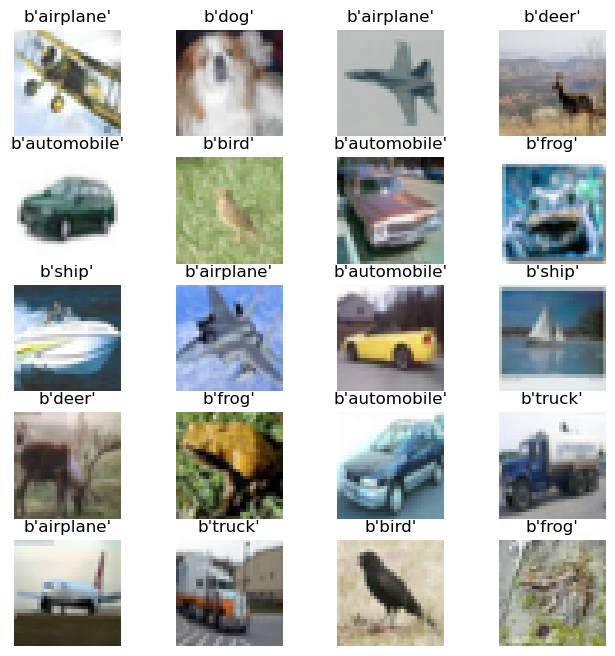

In [ ]:
fig = plt.figure(figsize=(8,8))
columns=4;
rows =5;
for i in range(1, columns*rows+1):
    img_xy = np.random.randint(len(data['data']))
    img = data['data'][img_xy]
    print(img.shape)
    imgd = img.transpose(1,2,0)
    fig.add_subplot(rows, columns, i)
    plt.title(label_names[data['labels'][img_xy]])
    plt.axis('off')
    plt.imshow(imgd, cmap='gray')
plt.show()